In [1]:
import sys
from google.colab import drive

drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/finance_course/2021/lesson3')

Mounted at /content/drive


## Overnight Index Swap

* Interest rate swaps (IRS) are usually used to mitigate the risks of fluctuations of varying interest rates, or to benefit from lower rates. 

* Overnight Index Swaps (OIS) are a particular kind of IRS which pay a floating coupon, determined by overnight rate fixings over the reference periods, against a fixed coupon.  
  * We will always look at these products from the point of view of the **receiver of the floating leg**.

* An OIS is defined by:
  * a notional amount $N$;
  * a starting date $d_0$;
  * a sequence of payment dates $d_1,...,d_n$;
  * a fixed rate $K$.

* For simplicity in the following we assume the fixed and floating legs to have the same notional and payment dates, although this is not necessarily always the case in practice.


### OIS Valuation

* To evaluate the NPV of such products the cash flows of each leg have to be calculated; then sum their discounted values.


#### Floating leg

* The floating leg pays a cash flow determined as follows:

$$f_{\mathrm{float},~i} = N \Bigg\{\prod_{d=d_{i-1}}^{d=d_i-1}\Big(1+r_{\mathrm{O/N}}(d)\cdot\frac{1}{360}\Big) -1 \Bigg\}$$

* This formula is valid for OIS swaps in EUR since the $\frac{1}{360}$ fraction appears because EONIA rates are quoted using the ACT/360 day-count convention.
  * Other currencies might have different conventions.  
  * In addition we are making the simplifying assumption of ignoring weekends and holidays:
    * each overnight rate is valid for only one day.

* The sum of the discounted expected values of these cash flows is

$$\mathrm{NPV}_{\mathrm{float}} = \sum_{i=1}^{n}D(d_i)\mathbb{E}[f_{\mathrm{float},~i}]$$

* where $D(d)$ is the discount factor with expiry $d$. 

* On the other hand, by definition 

$$\begin{equation*}
\prod_{i=d}^{d'} (1+r_i\tau_1) = \underbrace{(1+r_{d,d+1}\tau_1)\underbrace{(1+r_{d+1,d+2}\tau_1)\ldots\underbrace{(1+r_{d'-2,d'-1}\tau_1)(1+r_{d'-1,d'}\tau_1)}_{\textstyle =(1+r_{d'-2,d'}\tau_{d'-2,d')}}}_{\textstyle =(1+r_{d+1,d'}\tau_{d+1, d'})}}_{\textstyle =(1+r_{d,d'}\tau_{d,d'})}
\end{equation*}\\[40pt]$$

$$ (1+r_{0,d}\tau_{0,d})(1+r_{d,d'}\tau_{d,d'}) = (1+r_{0, d'}\tau_{0,d'}) \implies (1+r_{d,d'}\tau_{d,d'}) = \left(\cfrac{1+r_{0, d'}\tau_{0,d'}}{1+r_{0,d}\tau_{0,d}}\right)\\[30pt]$$

$$\mathbb{E}[f_{\mathrm{float},~i}] = N\cdot\left(\cfrac{D_{\mathrm{OIS}}(0, d_{i-1})}{D_{\mathrm{OIS}}(0, d_{i})} - 1\right)\qquad \mathrm{where}\ D_{\mathrm{OIS}}(0,d)=\cfrac{1}{1+r_{0,d}\tau_{0,d}}\\[20pt]$$


$$\mathrm{NPV}_{\mathrm{float}} = N\cdot \sum_{i=1}^{n}D(d_i) \left(\cfrac{D_{\mathrm{OIS}}(d_{i-1})}{D_{\mathrm{OIS}}(d_{i})} - 1\right)$$

* where $D_{\mathrm{OIS}}(d)$ is the discount factor implied by OIS prices (we will see how to derive it).

* Since the correct curve to discount OIS is the overnight index itself we have that $D = D_{\mathrm{OIS}}$ so the NPV simplifies to

$$
\begin{equation}
\begin{split}
\mathrm{NPV}_{\mathrm{float}} & = N\cdot\sum_{i=1}^{n}\left(D_{\mathrm{OIS}}(d_{i-1}\right) - D_{\mathrm{OIS}}(d_i)] =  \\
    &= N\cdot[(D_{\mathrm{OIS}}(d_{0}) - D_{\mathrm{OIS}}(d_{1})) + (D_{\mathrm{OIS}}(d_{1}) - D_{\mathrm{OIS}}(d_{2})) + \ldots + (D_{\mathrm{OIS}}(d_{n-1}) - D_{\mathrm{OIS}}(d_{n}))]\\
    &= N \cdot [D_{\mathrm{OIS}}(d_0) - D_{\mathrm{OIS}}(d_n)]
  \end{split}
\end{equation}
$$

#### Fixed leg
* The calculation for the fixed leg is simpler: each cash flow is  equal to

$$f_{\mathrm{fixed},~i}=N\cdot K\cdot \frac{d_i - d_{i-1}}{360}$$

* So the NPV of the fixed leg is

$$\mathrm{NPV}_{\mathrm{fixed}} = N\cdot K\cdot \sum_{i=1}^{n}D_{\mathrm{OIS}}(d_{i})\frac{d_i - d_{i-1}}{360}$$


### Discount Factor Determination from Market Quotes

* Our ultimate goal is to take a series of Overnight Index Swap quotations, and determine the discount factors implied by their prices. 
  * To do this we will build a class to represent OIS and compute its value given particular discount curve; 
  * then we will use this class, with a numerical optimizer, to *invert* the relation which connects the NPV to the discount curve so that the implied discount factors can be determined from OIS prices (market quotes).

In [6]:
# define OIS class
from finmarkets import generate_dates

class OvernightIndexSwap:
  def __init__(self, nominal, start_date, fixed_rate, maturity_months):
    self.nominal = nominal
    self.fixed_rate = fixed_rate
    self.payment_dates = generate_dates(start_date, maturity_months)

  def npv(self, dc):
    return self.npv_floating(dc) - self.npv_fixed(dc)

  def npv_floating(self, dc):
    return self.nominal*(dc.df(self.payment_dates[0]) - dc.df(self.payment_dates[-1]))

  def npv_fixed(self, dc):
    val = 0
    for i in range(1, len(self.payment_dates)):
      val += dc.df(self.payment_dates[i])*(self.payment_dates[i]-self.payment_dates[i-1]).days/360
    return self.nominal*self.fixed_rate*val


#### Example

In [ ]:
# test the class with a fake curve
from datetime import date
from finmarkets import DiscountCurve

ois = OvernightIndexSwap(
            1e6,
            date(2020, 10, 21),
            0.025, 36)

# fake discount curve
curve = DiscountCurve([date(2020, 10, 21), date(2021, 6, 1),
                       date(2022, 1, 1)],
                      [1.0, 0.98, 0.82])

print ("OIS NPV: {:.2f}".format(ois.npv(curve)))

OIS NPV: 116361.21


## Bootstrapping Technique 

* We would like to determine a discount curve starting from the market quotes of a set of Overnight Index Swaps with different maturities.

* The employed technique is called bootstrapping.
  * This is the ABC of financial mathematics, since you always need a
discount curve to price a contract. 
  * We concentrate on EONIA swaps in order to build an EUR discount curve.
* The asumption underlying bootstrapping is that market quotes represent the **fair** prices of the OIS so they make the swap NPVs null.
  * The fair price is an estimate of what a willing buyer would pay a willing seller for a given asset, assuming both have a reasonable knowledge of the asset's worthness.


### Building OIS Instances

* The first step involves getting data, the swap market quotes. 
  * This is not easy since EONIA swap market is over the counter (OTC) and it’s not straightforward to access it. 
  * Anyway in [ois_data.xlsx](https://github.com/matteosan1/finance_course/raw/develop/libro/input_files/ois_data.xlsx) it is available 
a dataset of swap quotes (which actually are rates rather prices) for our needs.


In [ ]:
# read and inspect ois_data.xlsx
import pandas as pd

mq = pd.read_excel("https://github.com/matteosan1/finance_course/raw/develop/libro/input_files/ois_data.xlsx")
mq.head()

,months,quote
0,1,-0.350
1,2,-0.347
2,3,-0.348
3,4,-0.350
4,5,-0.350


* Let’s build a 15 months swap instance using above input data. 
  * Be careful when doing this operation and double check the units of rates, quotes, etc...
  * For example quotes are expressed in percent so you need to multiply by 0.01 before using them;
  * another detail to check is that 15 months quote is not the fifteenth entry in the $\tt{DataFrame}$ (actually it is the twelfth).

In [ ]:
# create an OvernightIndexSwap with a market quote
ois = OvernightIndexSwap(1, date.today(),
                         mq.loc[mq['months']==15, 'quote'], 15)

ois.payment_dates[-1]

datetime.date(2023, 1, 25)

### Bootstrap Algorithm

* In finance, bootstrap is a method for constructing a (zero-coupon) yield curve from the prices of a set of coupon-bearing products (e.g. bonds and swaps). 
* The term structure of spot rates is obtained from the yields by solving for them recursively (by *forward substitution*): 
  * this iterative process is what is called the bootstrap method. 
* The usefulness of bootstrap is that using only few selected products, it is possible to derive forward and spot rates for all maturities.

* Let’s consider the following example which can be solved, at least partially, analytically.
* Select few bonds (yearly coupon of 4\%, 5\%, 6\%, 7\% and 8\% respectively) with
maturities ranging from 1 to 5 years, each having a value of €100 and traded at par (traded at its face value). 

* To determine the zero-coupon yield curve proceed as follows:
  1. at the end of first year the discounted cash flow of the first bond is €104 (principal plus the coupon) times the discount factor, so the implied 1 year rate 

$$100 = \cfrac{104}{(1 + S_{1y})}\implies S_{1y} =  104/100 - 1 = 4\%$$

  2. at the end of second year the sum of the cash flows of the second bond can be compared to its trading price to compute the 2-year spot rate $S_{2y}$ (using the previously derived value of $S_{1y}$)

$$100 = \cfrac{5}{(1 + S_{1y})} + \cfrac{105}{(1 + S_{2y})^{2}}$$
<br>
$$
100 = 5 / (1 + 0.04) + 105 / (1 + S_{2y})^{2}\qquad\Rightarrow\qquad S_{2y}^2  + 2 S_{2y}  - 0.103030 = 0 $$

* This second order equation can be solved either by hand or with `numpy.roots`.






In [ ]:
import numpy as np
np.roots([1, 2, -0.10303])

array([-2.05025235,  0.05025235])

$$S_{2y} = - 1 \pm \sqrt{1 + 0.103030} = \begin{cases}-2.05023 \\ 0.0502\end{cases}$$

* From the third year on we should obtain equation of third order or more:
  * they are not easily analitically solvable. 
  
* For example the equation for the fifth bond at the fifth year:

$$100 = \cfrac{8} {(1 + S_{1y})} + \cfrac{8} {(1 + S_{2y})^{2}}+ \cfrac{8} {(1 + S_{3y})^{3}} + \cfrac{8} {(1 + S_{4y})^{4}} + \cfrac{108} {(1 + S_{5y})^{5}}$$

* Assuming we have already determined the previous rates:

| years | coupon rate | bond price | rate|
|:----:|:----:|:----:|:----:|
|1 | 1.00 % | 100 | 4.00% |
|2 | 2.00 % | 100 | 5.02% |
|3 | 3.00 % | 100 | 6.08% |
|4 | 4.00 % | 100 | 7.19% |
|5 | 5.00 % | 100 | ??? |

* Previous equation can be solved numerically using for example Brent's algorithm.

![](https://drive.google.com/uc?id=1AmCejDf3ifMz9Zc6XOHeAk-5Tc23Zbrw)

In [ ]:
# find zeros of previous eq. with brentq
from scipy.optimize import brentq

def f(S):
  return 8/(1+0.04) + 8/(1+0.0502)**2 + 8/(1+0.0608)**3 + 8/(1+0.0719)**4 + 108/(1+S)**5 - 100

brentq(f, 0, 1)

0.0835929379032288

* The very same mechanism can be generalized to more maturities to get a more detailed yield curve: 

$$\begin{equation*}
\begin{cases}
f_1(S_1, p_1) = 0 \\
f_2(S_1, S_2, p_2) = 0 \\
f_3(S_1, S_2, S_3, p_3) = 0 \\
f_4(S_1, S_2, S_3, S_4, p_4) = 0 \\
\cdots
\end{cases}
\end{equation*}
$$
* where $S_i$ are the unknown spot rates and $p_i$ the market quotes of the considered products. 

* The iterative procedure we have applied before exploits the first equation to find $S_1 = f_1^{-1}(p_1)$, the second to find $S_2 = f_2^{-1}(S_1, p_2)$ and so on...

* This algorithm works since each equation will determine exactly one free spot rate which is not already determined by the others.


### Bootstrap as Minimization Problem

* Instead of iteratively finding the solution of each equation as before, we could:
  * define a vector of spot rates $\mathbf{S} = (S_1, S_2, S_3,\ldots)$;
  * seek for a particular $\mathbf{\hat{S}}$ which solves the following equation:

$$F = f_1^2(\hat{S}_1,p_1) + f_2^2(\hat{S}_1, \hat{S}_2,p_2) + f_3^2(\hat{S}_1, \hat{S}_2, \hat{S}_3,p_3) + f_4^2(\hat{S}_1, \hat{S}_2, \hat{S}_3, \hat{S}_4,p_4) + \ldots = 0$$

* Under this terms the bootstrap technique can be considered as a minimization problem;
  * indeed we need to find $\mathbf{\hat{S}}$ which makes $F$ zero, or at least *minimize* it making $F$ as close as possible to 0.
  * Notice that each $f_i$ is squared since we want all of them to be minimized at the same time and not only $F$ globally (without the squared there may be cancellation effects between the terms of the sum).


### Minimization Algorithm

* A minimization algorithm follows these steps:
  1. define an *objective function* i.e. the function that is actually minimized to reach our goal;
  2. set the initial value of the unknown parameters and their range of variability;
  3. the minimizer will compute the objective function value;
  4. then it will move the parameter values in such a way to find a smaller value of the objective function (e.g. following the derivative w.r.t. each parameter);
  5. if there are contraints the step above will take them into account;
  6. steps 4 and 5 are repeated until further variations of the $\mathbf{x}$ values won’t change significantly the objective function (i.e. we have found a minimum of the function so the minimisation process is completed !).

* In $\tt{python}$ the algorithm is implemented in $\tt{scipy.optimize.minimize}$

### Example 
* Find the dimensions that will minimize the costs to manufacture a cylindrical can of volume $330~\mathrm{cm}^3 (33~\mathrm{cl})$.

![](https://drive.google.com/uc?id=1LQaX8j10nq1KgRu4RdR4Ade96fsMNxa6)

* Minimize the costs means the company needs to reduce the can surface, given the required volume.

$$ S(r, h) = 2\pi rh + 2\cdot(\pi r^2) $$

* The volume is fixed to $330~\mathrm{cm}^3$ so we can remove $h$ from the previous equation:

$$ V = \pi r^2 h = 330\quad\implies h = \cfrac{330}{\pi r^2} $$

* The surface function to be minimized is:

$$ S(r) = 2\pi rh + 2\cdot(\pi r^2) = \cfrac{2\cdot 330}{r} + 2\cdot(\pi r^2)$$



In [ ]:
from math import pi
def surface(r):
  return 660/r + 2*pi*r**2

* Set the limits to our unknown variable and its initial value:

In [ ]:
r0 = [1]
bounds = [(0.01, 100)]

* Run the minimization:

In [3]:
from scipy.optimize import minimize
minimize(surface, r0, bounds=bounds)

NameError: ignored

* To minimize the cost the company should produce cans with a radius of about 3.745 cm.

### Example with Constraint

* You need to fence a rectangular field. 
  * If we look at the field from above the cost of the vertical sides are €10/m, the cost of the bottom is €2/m and the cost of the top is €7/m. 
  * If we have €700 determine the dimensions of the field that will maximize the enclosed area.

![](https://drive.google.com/uc?id=1JhL79-u0uDs8nkcEtletOWypdKWWZDBc)

* In this example there are two differences w.r.t before:
  * we want to maximize a quantity (not minimize);
  * there is a contraint (we have a limited amount of money).

* The objective is to **maximize** the enclosed area $A$ so we can **minimize** the quantity $-A$. 
* Further define length and width of the field with $\tt{x[0]}$ and $\tt{x[1]}$ (items of the list $\tt{x}$).

In [ ]:
def of(x):
  return -x[0]*x[1]

* Set the boundaries for length and width and their initial values (1 m each):

In [ ]:
x0 = [.1,.1]
bounds = [(.1, 100) for _ in range(len(x0))]

* We need to impose the constraint on the money.
* This is done by defining a function that computes the money spent with the fence and compare it to €700.
* The constraint is passed to the minimizer as a dictionary which has two keys: 
  * $\tt{type}$ with value $\tt{eq}$ (like equality) since we want to spend all of our available money so the fence has to cost €700

$$\mathrm{fence~cost} = l\cdot10 + l\cdot10 + w\cdot2 + w\cdot7 = 700$$
$$l\cdot10 + l\cdot10 + w\cdot2 + w\cdot7 - 700 = 0$$

  * $\tt{fun}$ whose value is the constraint function. 

In [ ]:
def pippo(x):
  return x[0]*10*2 +x[1]*2+x[1]*7-700

constr = {"type":"eq", "fun":pippo}

* Run the minimizer.

In [ ]:
from scipy.optimize import minimize

minimize(of, x0, bounds=bounds, constraints=constr)

     fun: -680.5555555555493
     jac: array([-38.8888855, -17.5      ])
 message: 'Optimization terminated successfully.'
    nfev: 16
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([17.50000167, 38.88888518])

* So the field will come out $17.5$ m long and $38.9$ m wide.

# Recap

1. Introduced Overnight Index Swap contract
  * exchange floating coupon based on EONIA rates with fixed rate
  * found that NPV$_{\textrm{OIS}}$(discount curve$_{\textrm{EONIA}}$)
2. Our goal is to determine EONIA rates implied by market quotes (prices) of OIS
3. Defined Bootstrap algorithm which allows to *invert* the relationship between NPV and discount curve to get **rates**
  * Two alternative ways:
    * Forward substitution (bond example): 
$$\begin{equation*}
\begin{cases}
f_1(S_1, p_1) = 0 \implies S_1 = f_1^{-1}(p_1)\\
f_2(S_1, S_2, p_2) = 0 \implies S_2 = f_2^{-1}(S_1, p_2)\\
f_3(S_1, S_2, S_3, p_3) = 0 \implies \ldots\\
f_4(S_1, S_2, S_3, S_4, p_4) = 0 \\
\cdots
\end{cases}
\end{equation*}
$$
  * Minimization:
    * define a vector of spot rates $\mathbf{S} = (S_1, S_2, S_3,\ldots)$ and look for $\mathbf{\hat{S}}$ which solves the following equation:

$$F = f_1^2(\hat{S}_1,p_1) + f_2^2(\hat{S}_1, \hat{S}_2,p_2) + f_3^2(\hat{S}_1, \hat{S}_2, \hat{S}_3,p_3) + f_4^2(\hat{S}_1, \hat{S}_2, \hat{S}_3, \hat{S}_4,p_4) + \ldots = 0$$

  * Finally we saw minimization algorithm examples to understand how it works.

## Local Minima

In [ ]:
import numpy as np
from math import pi

def func(x):
    return np.cos(3*pi*x)/x

![](https://drive.google.com/uc?id=1NarHa2FYJxDT6nq_sm6H57PUJcwHBxxx)

In [ ]:
from scipy.optimize import minimize
x0 = [1.1]
bounds = [(0.01, 2)]

r = minimize(func, x0, bounds=bounds)
print (r)

      fun: array([-1.00569871])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.4408921e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 16
      nit: 5
   status: 0
  success: True
        x: array([0.98865633])


In [ ]:
from scipy.optimize import minimize
x0 = [0.5]
bounds = [(0.01, 2)]

r = minimize(func, x0, bounds=bounds)
print (r)

      fun: array([-3.17151711])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([9.32587341e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 16
      nit: 5
   status: 0
  success: True
        x: array([0.29691798])


### Back to OIS Example

1. Market quotes represent the OIS *fair* prices, so their NPV's should be close to 0 (i.e. NPVs are the $f_i$);

$$\begin{equation}
\mathrm{Objective Function} =	\sum_{i=1}^{n}\mathrm{NPV}^\mathrm{OIS}_i(\mathcal{C})^2
\end{equation}$$

2.  Given the characteristics of the OIS the only unknown parameter of each NPV is the discount curve $\mathcal{C}$ (i.e. **the algorithm will adjust the unknown discount factors of $\mathcal{C}$ to reach the minimum**).
  * In the previous examples the number of minimization parameters (i.e. the degrees of freedom of the problem) was clear:
      * 1 for the can example, the can radius;
      * 2 for the fence problem, width and height of the field.

  * A discount curve is characterized by pillar dates ($\mathbf{d}$) and discount factors ($\mathbf{x}$):
      * we haven't yet identified a constraint on how many points the curve is made of (too many or too few points may prevent us from finding the solution).
  * **In practice, it makes sense to choose the number of degrees of freedom to match the number of market quotes.** 
      * In particular it is wise to choose the pillar dates of the discount curve equal to the set of the swap expiry dates and **leave as unknown parameters the discount factors**.

$$\begin{equation}
 \mathrm{min}_{\mathbf{x}} \left\{\sum_{i=1}^{N}\mathrm{NPV}^\mathrm{OIS}_i( \mathcal{C}(\mathbf{x}))^2\right\}
\end{equation}$$

* First create the swaps according to all the available market quotes and also the pillar dates of our final discount curve:

![](https://drive.google.com/uc?id=1KU4hoZfIVO3cTrf4rFcjCyBjtWsqiIZh)

The file can be downloaded from here: [ois_2021_10_14.xlsx](https://github.com/matteosan1/finance_course/blob/develop/libro/input_files/ois_2021_10_14.xlsx?raw=true)

In [5]:
# inspect tha file
import pandas as pd

df = pd.read_excel("https://github.com/matteosan1/finance_course/blob/develop/libro/input_files/ois_2021_10_14.xlsx?raw=true")
print (df.head())

   months   quote
0       1 -0.4846
1       2 -0.4842
2       3 -0.4845
3       4 -0.4840
4       5 -0.4835


In [8]:
# creates the OIS from market quotes
from finmarkets import generate_dates
from datetime import date

pricing_date = date.today()
pillar_dates = [pricing_date]
swaps = [] 

for q in range(len(df)):
  s = OvernightIndexSwap(1e6, pricing_date, 
                         df.loc[q, 'quote']*0.01,
                         df.loc[q, 'months'])
  swaps.append(s)
  pillar_dates.append(s.payment_dates[-1])

* Define the objective function: the sum of the squared NPVs of the OIS 

In [9]:
# define objective function
import numpy as np
from finmarkets import DiscountCurve

def of(x):
  dc = DiscountCurve(pillar_dates, x)

  F = 0
  for s in swaps:
    F += s.npv(dc)**2

  return F

* Set the initial value of the discount factors ($x_i$) to 1 with a range of variability $[ 0.01, 10]$, in addition the first element of the list, today’s discount factor, will be fixed to 1 (variability $[1, 1]$)

In [13]:
# set boundaries and guess values
x0 = [0.51 for _ in range(len(pillar_dates))]
bounds = [(0.01, 10.0) for _ in range(len(pillar_dates))]
bounds[0] = (1, 1)

* Launch the minimizer to find the discount factors ($\mathbf{x}$)

In [15]:
# minimize
from scipy.optimize import minimize
res = minimize(of, x0, bounds=bounds)
print (res)

      fun: 0.0007412041379502624
 hess_inv: <32x32 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.13078156e+05,  2.77450578e-04,  2.40931938e-04,  2.00295271e-04,
        1.87727069e-04, -9.07650691e-07, -3.13010685e-05, -2.10405218e-04,
        2.35703709e-05, -1.65382389e-04,  3.31089182e-04,  5.41493044e-04,
       -2.49984040e-04, -3.26207518e-04, -5.21673525e-04,  8.53650310e-04,
        5.72948438e-04,  2.52836641e-04, -3.06683281e-05, -6.94720323e-05,
       -1.36108269e-04, -1.03503577e-05, -1.60351962e-04,  1.02804462e-04,
       -3.77279653e-04, -5.62855372e-04, -3.76742832e-04, -4.03580533e-04,
       -1.20225217e-04,  4.31901693e-05,  2.08625651e-04,  4.14797699e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 396
      nit: 9
   status: 0
  success: True
        x: array([1.        , 1.00041746, 1.00082112, 1.0012397 , 1.0016564 ,
       1.00203213, 1.00244425, 1.00284   , 1.00324509, 1.00363034,
       1.00402045, 1.00440408, 1.

* Some diagnostic number/plot.

In [16]:
# print initial and final objective function values
print (of(x0))
print (of(res.x))

29729806749.83658
0.0007412041379502624


![](https://drive.google.com/uc?id=1vSGqJgICkStJHDkwqZC49gcsPget3fgg)
![](https://drive.google.com/uc?id=1dTW0l_RZfD6OPI1x0WOR1AGgjLp_luZq)


* Finally we can create the discount curve implied by the market quote of our swaps. 

$$ \mathrm{df} = e^{-rt} \quad\implies \mathrm{log(df)} = -rt\quad\implies r = -\mathrm{log(df)}/t$$

In [17]:
# create the discount curve with our factors
from math import log
from dateutil.relativedelta import relativedelta
from finmarkets import DiscountCurve

dc = DiscountCurve(pillar_dates, res.x)

d = pricing_date  + relativedelta(years=20)
r = -log(dc.df(d))/20
print (r)

0.00464148979693775


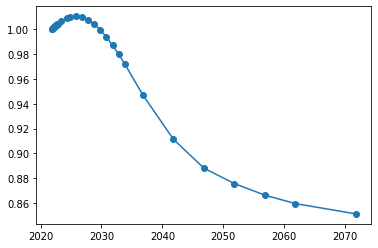

In [18]:
from matplotlib import pyplot as plt

plt.plot(pillar_dates, res.x, marker='o')
plt.show()